In [1]:
'''
File name: Project.ipynb
Author: Paul de Fontenay, Arnault Monoyer, Jules Orsat and Matthieu Sayar
Date created: 01/11/2022
Date last modified: 03/11/2022
Last modification by: Matthieu Sayar
Python Version: 3.9.13
'''

'\nFile name: Project.ipynb\nAuthor: Paul de Fontenay, Arnault Monoyer, Jules Orsat and Matthieu Sayar\nDate created: 01/11/2022\nDate last modified: 03/11/2022\nLast modification by: Matthieu Sayar\nPython Version: 3.9.13\n'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

DATA_FOLDER = 'MovieSummaries/'

In [3]:
moviedata = pd.read_csv(DATA_FOLDER + 'movie.metadata.tsv', sep = '\t', index_col='wiki_id' , header=None, names=('wiki_id','freebase_id','movie_name','release','revenue','runtime','languages','countries','genres'))
charadata = pd.read_csv(DATA_FOLDER + 'character.metadata.tsv', sep = '\t', header=None, names=('wiki_id','freebase_id','release','character_name','actor_dob','actor_gender','actor_height','actor_ethnicity','actor_name','actor_age','freebase_chara_map','1','2'))
plots =  pd.read_csv(DATA_FOLDER + 'plot_summaries.txt', sep = '\t', header=None, names=('wiki_id','plot'))

In [4]:
charadata.set_index('wiki_id',inplace=True)
plots.set_index('wiki_id',inplace=True)

### Movie data analysis

In [5]:
indexes = moviedata.index.intersection(charadata.index)
indexes = plots.index.intersection(indexes)

moviedata_filtered = moviedata.loc[indexes]
charadata_filtered = charadata.loc[indexes]
plots_filtered = plots.loc[indexes]

In [6]:
print(len(moviedata),len(moviedata_filtered))
print(len(charadata),len(charadata_filtered))
print(len(plots),len(plots_filtered))

81741 37779
450669 308485
42303 37779


In [7]:
moviedata_filtered.isna().sum()

freebase_id        0
movie_name         0
release         1757
revenue        30283
runtime         5209
languages          0
countries          0
genres             0
dtype: int64

In [8]:
"""moviedata_filtered['release'] = moviedata_filtered['release'].apply(lambda x: charadata_filtered.loc[x.index]['release'] if (x is None) else x)
moviedata_filtered.isna().sum()"""

"moviedata_filtered['release'] = moviedata_filtered['release'].apply(lambda x: charadata_filtered.loc[x.index]['release'] if (x is None) else x)\nmoviedata_filtered.isna().sum()"

In [9]:
moviedata_filtered.loc[:,'genres'] = moviedata_filtered['genres'].apply(lambda x : x.replace(':', ','))

moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(eval)
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda x: list(x))
moviedata_filtered['genres'] = moviedata_filtered['genres'].apply(lambda y: list(filter(lambda x: not x.startswith('/m'), y)))

In [10]:
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

<AxesSubplot:>

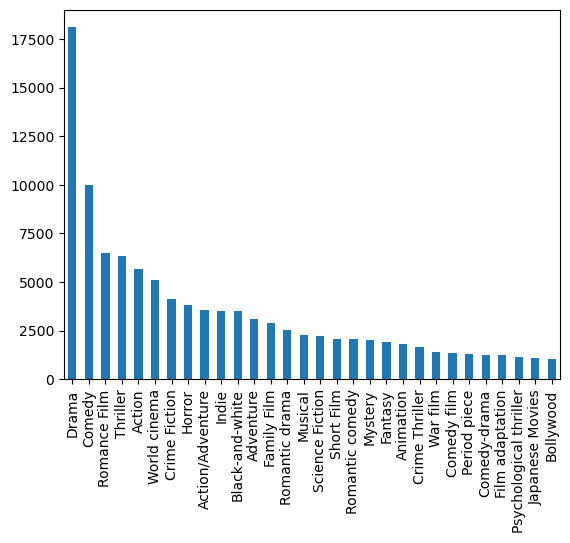

In [11]:
a = to_1D(moviedata_filtered['genres']).value_counts()

a = a[a>1000]

a.plot(kind='bar')

In [12]:
selected_genres = ['Comedy','Action','Horror']

for genre in selected_genres:
    moviedata_filtered[genre] = moviedata_filtered['genres'].apply(lambda x: 1 if genre in x else 0)

moviedata_filtered['unique_genre'] = moviedata_filtered.loc[:,selected_genres].sum(axis = 1)

In [13]:
unique_genre = moviedata_filtered.drop(moviedata_filtered[moviedata_filtered['unique_genre'] != 1].index)

<AxesSubplot:>

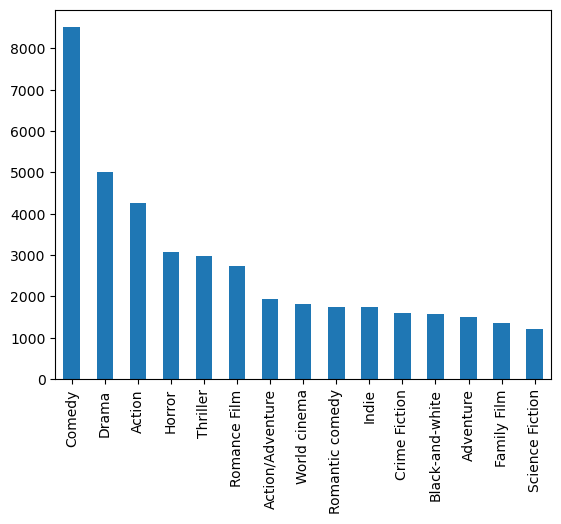

In [14]:
a = to_1D(unique_genre['genres']).value_counts()

a = a[a>1000]

a.plot(kind='bar')

In [15]:
unique_genre.head()

,freebase_id,movie_name,release,revenue,runtime,languages,countries,genres,Comedy,Action,Horror,unique_genre
wiki_id,,,,,,,,,,,,
31186339,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Science Fiction, Action, Drama, Action/Advent...",0,1,0,1
20663735,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}","[Musical, Bollywood, Action, Drama]",0,1,0,1
2231378,/m/06xtz3,The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Screwball comedy, Comedy]",1,0,0,1
5272176,/m/0dbxtv,End Game,2006,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...","[Thriller, Action, Drama, Action/Adventure]",0,1,0,1
1952976,/m/068jvg,Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","[Horror, Thriller, Drama]",0,0,1,1


In [16]:
for genre in selected_genres:
    unique_genre['genres'] = unique_genre['genres'].apply(lambda x: genre if genre in x else x)

In [17]:
unique_genre.head()

,freebase_id,movie_name,release,revenue,runtime,languages,countries,genres,Comedy,Action,Horror,unique_genre
wiki_id,,,,,,,,,,,,
31186339,/m/0gkz15s,The Hunger Games,2012-03-12,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Action,0,1,0,1
20663735,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}",Action,0,1,0,1
2231378,/m/06xtz3,The Lemon Drop Kid,1951-03-08,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Comedy,1,0,0,1
5272176,/m/0dbxtv,End Game,2006,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...",Action,0,1,0,1
1952976,/m/068jvg,Dark Water,2005-06-27,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Horror,0,0,1,1


In [18]:
unique_genre['release'] = pd.DatetimeIndex(unique_genre['release']).year
unique_genre = unique_genre[unique_genre['release'].notna()]
unique_genre['release'] = unique_genre['release'].astype(int)


unique_genre['decade'] = (unique_genre['release']//10)*10
unique_genre['year'] = unique_genre['release']%10


In [19]:
unique_genre.head()

,freebase_id,movie_name,release,revenue,runtime,languages,countries,genres,Comedy,Action,Horror,unique_genre,decade,year
wiki_id,,,,,,,,,,,,,,
31186339,/m/0gkz15s,The Hunger Games,2012,686533290.0,142.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Action,0,1,0,1,2010,2
20663735,/m/051zjwb,Narasimham,2000,NaN,175.0,"{""/m/0999q"": ""Malayalam Language""}","{""/m/03rk0"": ""India""}",Action,0,1,0,1,2000,0
2231378,/m/06xtz3,The Lemon Drop Kid,1951,2300000.0,91.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Comedy,1,0,0,1,1950,1
5272176,/m/0dbxtv,End Game,2006,NaN,93.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America"", ""/m/...",Action,0,1,0,1,2000,6
1952976,/m/068jvg,Dark Water,2005,49483352.0,105.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}",Horror,0,0,1,1,2000,5


In [20]:
comedy = unique_genre.loc[unique_genre['genres'] == 'Comedy'].copy()
comedy_rev = comedy['revenue'].mean()
action = unique_genre.loc[unique_genre['genres'] == 'Action'].copy()
action_rev = action['revenue'].mean()
horror = unique_genre.loc[unique_genre['genres'] == 'Horror'].copy()
horror_rev = horror['revenue'].mean()


In [21]:
print(comedy_rev)
print(action_rev)
print(horror_rev)

49221245.9323692
98711644.14473684
43040723.65815324


In [22]:
comedy_count = comedy['revenue'].count()
horror_count = horror['revenue'].count()
action_count = action['revenue'].count()

In [23]:
print(comedy_count)
print(action_count)
print(horror_count)

2351
1064
509


<AxesSubplot:xlabel='decade'>

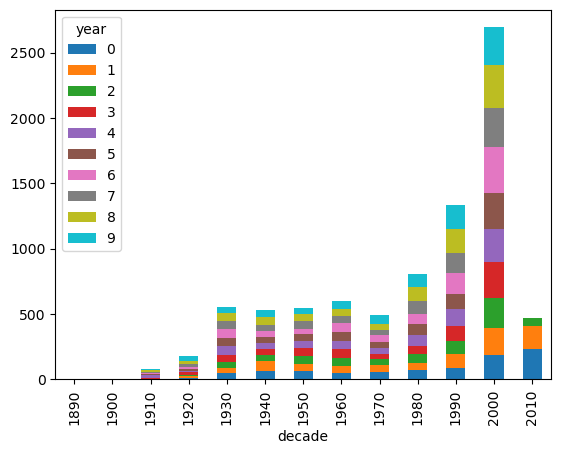

In [24]:
comedy.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(stacked=True)

<AxesSubplot:xlabel='decade'>

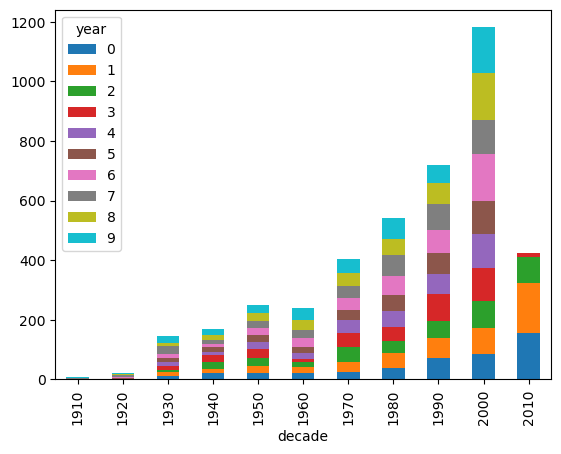

In [25]:
action.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(stacked=True)

<AxesSubplot:xlabel='decade'>

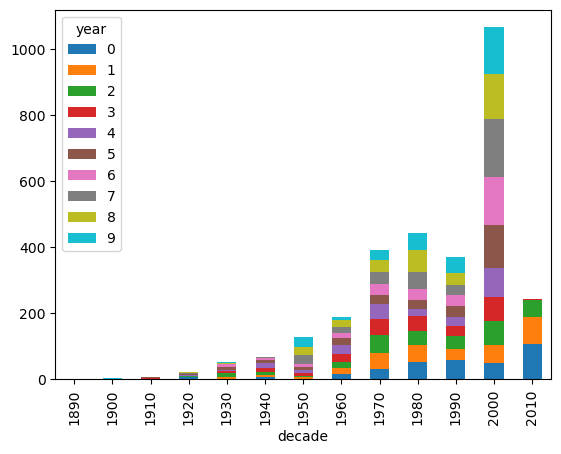

In [26]:
horror.groupby(['decade', 'year'])['release'].count().unstack().plot.bar(stacked=True)

### Character data analysis

In [27]:
charadata.head()

,freebase_id,release,character_name,actor_dob,actor_gender,actor_height,actor_ethnicity,actor_name,actor_age,freebase_chara_map,1,2
wiki_id,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [28]:
charadata_filtered = charadata_filtered.drop(['freebase_id','freebase_chara_map','1','2'], axis = 1)

In [29]:
comedy_chardata = charadata_filtered.loc[comedy.index.intersection(charadata_filtered.index)]
action_chardata = charadata_filtered.loc[action.index.intersection(charadata_filtered.index)]
horror_chardata = charadata_filtered.loc[horror.index.intersection(charadata_filtered.index)]

In [30]:
comedy_chardata = comedy_chardata.groupby('wiki_id')
nb_characters = comedy_chardata['actor_gender'].count()
comedy.loc[:,'nb_characters'] = nb_characters

In [31]:
comedy['nb_women'] = comedy_chardata['actor_gender'].apply(lambda x: x[x == 'F'].count())
comedy['nb_men'] = comedy_chardata['actor_gender'].apply(lambda x: x[x == 'M'].count())
comedy['ratio_gender'] = comedy['nb_women'] / comedy['nb_men']